# PGA project
- Is it possible to predict 'making the cut' or not at a PGA event?

- Making the cut is important for players and sponsors alike. 
    - A typical PGA event is 4 rounds of golf. Thursday - Sunday
    - 'The top 70 players (including ties) make the cut. Any player in 71st place or worse (after Friday's round) is cut.' - pga.com

- From a players perspective, making the cut is important for many reasons. 
    - If a player misses the weekend, they do not get paid.
    - Also, prized FEDEX cup points are missed. ('The FedEx Cup is the central professional golf competition that compares player performance across part of the PGA Tour season in a League and Playoffs structure.')
    - For continued poor performance, their tour eligibilty could be in jeopardy. 

- From a sponsors perspective, making the cut equates to 'eyes on product'.
    - Players making the weekend are televised more. Sunday draws the largest viewership of the tournament days. 
        - 2-4 million viewers for non-majors
        - 5 million for majors
        - 10 million for 'The Masters'

- This data science project will attempt to predict whether or not a player will make the cut, based on previous weeks performance, coupled with season averages(drive distance, fairway percentage, putting average). 


In [1]:
import pandas as pd
import itertools
import numpy as np
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats import levene

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor

#import r2
from sklearn.metrics import r2_score

import env
import acquire as a
import wrangle as w
import explore as e
import prepare as prep
import evaluate as eva
import pretty as muah
import knear as k

import warnings
warnings.filterwarnings("ignore")

# Data Dictionary

| Variable               | Description                           |
|------------------------|---------------------------------------|
| date                   | Date of the event                       |
| course                 | Name of the golf course                 |
| tournament name        | Name of the tournament                   |
| made_cut               | Indicator of whether the player made the cut or not |
| sg_putt_prev           | Strokes gained/lost putting in previous events |
| sg_arg_prev            | Strokes gained/lost around-the-green in previous events |
| sg_app_prev            | Strokes gained/lost approach in previous events |
| sg_ott_prev            | Strokes gained/lost off-the-tee in previous events |
| sg_t2g_prev            | Strokes gained/lost tee-to-green in previous events |
| sg_total_prev          | Total strokes gained/lost in previous events |
| driving_avg            | Distance of the player's drives in yards |
| fairways_hit           | Percentage of fairways hit by the player |
| putting_avg            | Average number of putts per hole        |
       


# Acquire
- Read CSV from downloaded source
- check for nulls
- drop nulls

In [2]:
# get data set
df = pd.read_csv('PGA_data.csv', index_col=0) 
df.T

player,Robert Allenby,Robert Allenby,Robert Allenby,Robert Allenby,Robert Allenby,Robert Allenby,Robert Allenby,Robert Allenby,Robert Allenby,Robert Allenby,...,Matthew Wolff,Matthew Wolff,Matthew Wolff,Matthew Wolff,Matthew Wolff,Matthew Wolff,Matthew Wolff,Matthew Wolff,Matthew Wolff,NaN
Height cm,185.0,185.0,185.0,185.0,185.0,185.0,185.0,185.0,185.0,185.0,...,183.0,183.0,183.0,183.0,183.0,183.0,183.0,183.0,183.0,NaN
Weight lbs,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,...,165.0,165.0,165.0,165.0,165.0,165.0,165.0,165.0,165.0,NaN
DOB,12/07/1971,12/07/1971,12/07/1971,12/07/1971,12/07/1971,12/07/1971,12/07/1971,12/07/1971,12/07/1971,12/07/1971,...,14/04/1999,14/04/1999,14/04/1999,14/04/1999,14/04/1999,14/04/1999,14/04/1999,14/04/1999,14/04/1999,NaN
Age,46.0,47.0,47.0,47.0,47.0,48.0,48.0,48.0,48.0,48.0,...,21.0,21.0,21.0,21.0,21.0,21.0,22.0,22.0,22.0,NaN
player id,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,4412121.0,4412121.0,4412121.0,4412121.0,4412121.0,4412121.0,4412121.0,4412121.0,4412121.0,NaN
date,29/10/2017,20/05/2018,10/06/2018,15/07/2018,23/07/2018,24/02/2019,31/03/2019,14/07/2019,21/07/2019,22/09/2019,...,26/07/2020,02/08/2020,09/08/2020,23/08/2020,30/08/2020,20/09/2020,11/10/2020,18/10/2020,25/10/2020,NaN
course,"Country Club of Jackson - Jackson, MS","Trinity Forest - Dallas, TX","TPC Southwind, Memphis, TN","TPC Deere Run - Silvis, IL","Keene Trace - Nicholasville, KY","Coco Beach - Rio Grande, Puero Rico","Corales Puntacana GC - Punta Cana, Dominican Republic","TPC Deere Run - Silvis, IL","Keene Trace - Nicholasville, KY","Country Club of Jackson - Jackson, MS",...,"TPC Twin Cities - Blaine, MN","TPC Southwind, Memphis, TN","TPC Harding Park - San Francisco, CA","TPC Boston - Norton, MA","Olympia Fields Country Club - Olympia Fields, IL","Winged Foot GC - Mamaroneck, NY","TPC Summerlin - Las Vegas, NV","Shadow Creek GC - Las Vegas, NV","Sherwood CC - Thousand Oaks, CA",NaN
tournament name,Sanderson Farms Championship,AT&T Byron Nelson,FedEx St. Jude Classic,John Deere Classic,Barbasol Championship,Puerto Rico Open,Corales Puntacana Resort & Club Championship,John Deere Classic,Barbasol Championship,Sanderson Farms Championship,...,3M Open,WGC-FedEx St. Jude Classic,PGA Championship,The Northern Trust,BMW Championship,U.S. Open,Shriners Hospital for Children Open,The CJ Cup @ Shadow Creek,The ZOZO Championship,NaN
tournament id,3763.0,401025251.0,401025254.0,401025258.0,401025271.0,401056517.0,401056525.0,401025258.0,401025271.0,3763.0,...,401155472.0,401056559.0,401025263.0,401025265.0,401056543.0,401025255.0,3768.0,401219796.0,401148239.0,NaN
season,2018.0,2018.0,2018.0,2018.0,2018.0,2019.0,2019.0,2019.0,2019.0,2020.0,...,2020.0,2020.0,2020.0,2020.0,2020.0,2021.0,2021.0,2021.0,2021.0,NaN


In [3]:
# check out how many rows of data
df.shape

(14041, 63)

In [4]:
# check for null values
df.isnull().sum()

Height cm                   1
Weight lbs                  1
DOB                         1
Age                         1
player id                   1
date                        1
course                      1
tournament name             1
tournament id               1
season                      1
final position              1
major                       1
made_cut                    1
Consecutive_Cuts_Made     320
Finish                      1
Score                    2385
sg_putt                  2385
sg_arg                   2385
sg_app                   2385
sg_ott                   2385
sg_t2g                   2385
sg_total                 2385
sg_putt_prev             2559
sg_arg_prev              2559
sg_app_prev              2559
sg_ott_prev              2559
sg_t2g_prev              2559
sg_total_prev            2385
place                       1
Number of Rounds            1
Drive Yards                 1
Fairways Hit                1
PUTTS/HOLE                  1
maxtempC  

In [5]:
# dropped all nulls
df = df.dropna()

- now have 9819 rows down from 14041

# Prepare
- make all columns lower case for ease of use
- drop columns unnecessary to this study
- rename columns for readability/understanding
- perform univariate analysis
- view and understand descriptive statistics through a comprehensive dataframe summary

In [6]:
#lower case all column names
df.columns  = df.columns.str.lower()
df.head()

,height cm,weight lbs,dob,age,player id,date,course,tournament name,tournament id,season,...,visibility,winddirdegree,windspeedkmph,greensgrass,fariwaysgrass,water,bunkers,slope,length,par
player,,,,,,,,,,,,,,,,,,,,,
Robert Allenby,185.0,180.0,12/07/1971,47.0,5.0,20/05/2018,"Trinity Forest - Dallas, TX",AT&T Byron Nelson,401025251.0,2018.0,...,9.0,208.0,11.0,2.0,8.0,1.0,4.0,134.0,7447.0,72.0
Robert Allenby,185.0,180.0,12/07/1971,47.0,5.0,10/06/2018,"TPC Southwind, Memphis, TN",FedEx St. Jude Classic,401025254.0,2018.0,...,10.0,211.0,11.0,1.0,8.0,1.0,7.0,149.0,7244.0,70.0
Robert Allenby,185.0,180.0,12/07/1971,47.0,5.0,15/07/2018,"TPC Deere Run - Silvis, IL",John Deere Classic,401025258.0,2018.0,...,8.0,237.0,6.0,1.0,1.0,1.0,6.0,138.0,7258.0,71.0
Robert Allenby,185.0,180.0,12/07/1971,47.0,5.0,23/07/2018,"Keene Trace - Nicholasville, KY",Barbasol Championship,401025271.0,2018.0,...,10.0,149.0,9.0,1.0,1.0,1.0,3.0,139.0,7334.0,72.0
Robert Allenby,185.0,180.0,12/07/1971,48.0,5.0,21/07/2019,"Keene Trace - Nicholasville, KY",Barbasol Championship,401025271.0,2019.0,...,10.0,97.0,22.0,1.0,1.0,1.0,3.0,139.0,7334.0,72.0


In [7]:
# this study focuses on performance the previous week. Therefore, I am dropping the following columns
df = df.drop(columns=['height cm', 'weight lbs', 'dob', 'age','player id', 'tournament id',
                'season', 'visibility', 'winddirdegree', 'windspeedkmph', 'greensgrass','fariwaysgrass', 
                'water','bunkers', 'windchillc','windgustkmph', 'cloudcover', 'humidity','precipmm','pressure',
                'tempc', 'final position', 'major', 'consecutive_cuts_made', 'finish','moonrise', 'sunrise',
                'sunset', 'dewpointc', 'feelslikec', 'heatindexc', 'maxtempc','mintempc','totalsnow_cm', 'sunhour',
                'uvindex', 'moon_illumination', 'moonset', 'place','number of rounds', 'sg_putt','sg_arg','sg_app',
                'sg_ott', 'sg_t2g', 'sg_total', 'score', 'slope','length','par'])

In [8]:
df = df.rename(columns={'tournament name':'tournament_name', 'drive yards':'driving_avg',
                        'fairways hit':'fairways_hit', 'putts/hole':'putting_avg'})

In [9]:
# check it out dataframe after removal of unneccessary columns
df.head()

,date,course,tournament_name,made_cut,sg_putt_prev,sg_arg_prev,sg_app_prev,sg_ott_prev,sg_t2g_prev,sg_total_prev,driving_avg,fairways_hit,putting_avg
player,,,,,,,,,,,,,
Robert Allenby,20/05/2018,"Trinity Forest - Dallas, TX",AT&T Byron Nelson,1.0,0.17,-0.93,0.65,-0.30,-0.57,-0.40,286.9,65.6,1.84
Robert Allenby,10/06/2018,"TPC Southwind, Memphis, TN",FedEx St. Jude Classic,0.0,1.06,-1.32,-1.07,-0.73,-3.12,-2.07,286.9,65.6,1.84
Robert Allenby,15/07/2018,"TPC Deere Run - Silvis, IL",John Deere Classic,0.0,-1.07,-0.48,0.71,-0.01,0.22,-0.85,286.9,65.6,1.84
Robert Allenby,23/07/2018,"Keene Trace - Nicholasville, KY",Barbasol Championship,0.0,-1.78,-0.18,-0.77,-0.52,-1.47,-3.25,286.9,65.6,1.84
Robert Allenby,21/07/2019,"Keene Trace - Nicholasville, KY",Barbasol Championship,0.0,-2.32,-0.31,-1.75,-0.35,-2.40,-4.73,293.8,60.7,1.77


In [10]:
#change tournament date to datetime
df.date = pd.to_datetime(df.date)

In [11]:
# verify date are correctly changed to datetime format
df.dtypes

date               datetime64[ns]
course                     object
tournament_name            object
made_cut                  float64
sg_putt_prev              float64
sg_arg_prev               float64
sg_app_prev               float64
sg_ott_prev               float64
sg_t2g_prev               float64
sg_total_prev             float64
driving_avg               float64
fairways_hit              float64
putting_avg               float64
dtype: object

### Univariate analysis
- Check out distributions of variables in the dataset


SUMMARY REPORT
          
          
Dataframe head: 
                     date                           course  \
player                                                       
Robert Allenby 2018-05-20      Trinity Forest - Dallas, TX   
Robert Allenby 2018-10-06       TPC Southwind, Memphis, TN   
Robert Allenby 2018-07-15       TPC Deere Run - Silvis, IL   
Robert Allenby 2018-07-23  Keene Trace - Nicholasville, KY   
Robert Allenby 2019-07-21  Keene Trace - Nicholasville, KY   

                       tournament_name  made_cut  sg_putt_prev  sg_arg_prev  \
player                                                                        
Robert Allenby       AT&T Byron Nelson       1.0          0.17        -0.93   
Robert Allenby  FedEx St. Jude Classic       0.0          1.06        -1.32   
Robert Allenby      John Deere Classic       0.0         -1.07        -0.48   
Robert Allenby   Barbasol Championship       0.0         -1.78        -0.18   
Robert Allenby   Barbasol Championshi

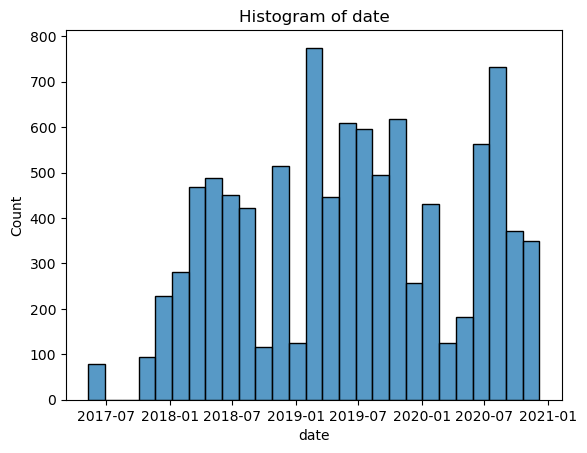

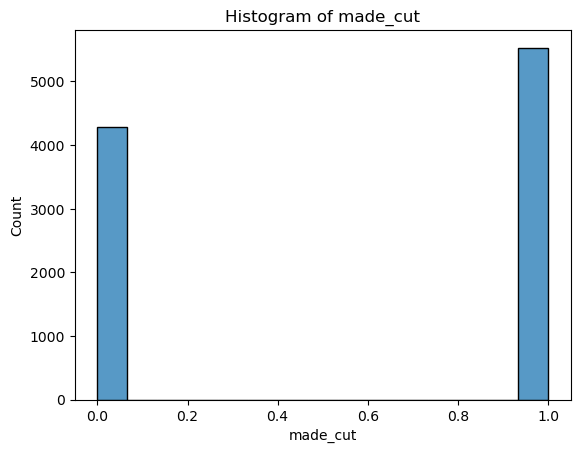

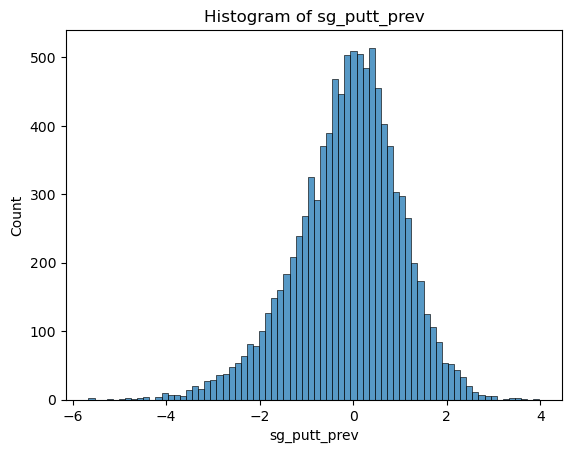

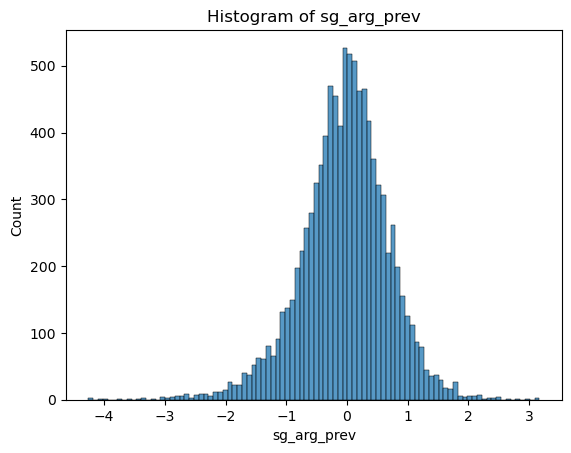

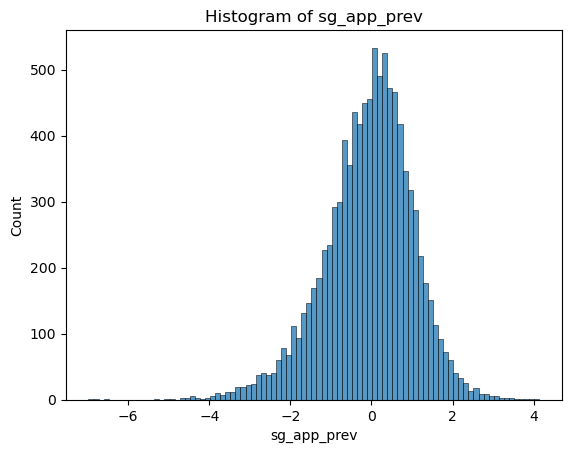

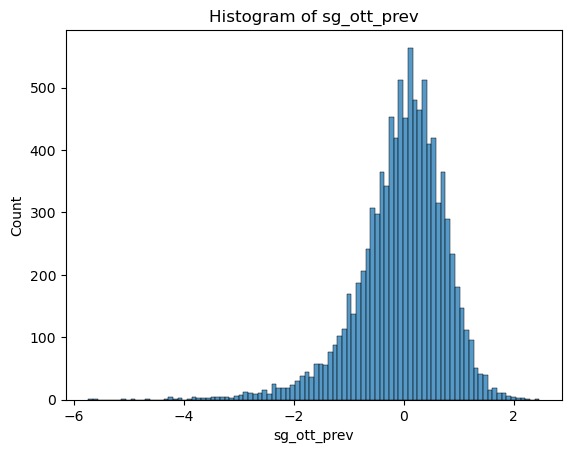

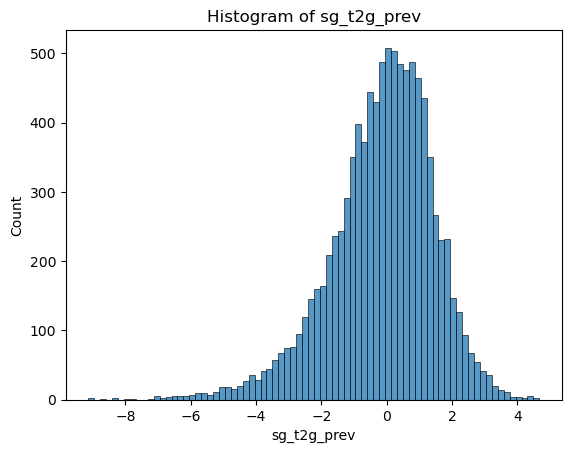

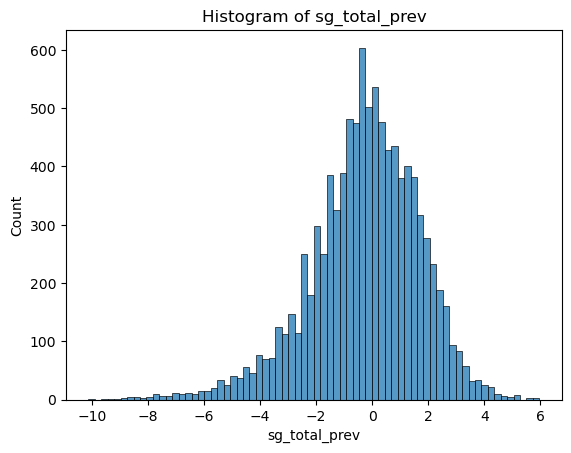

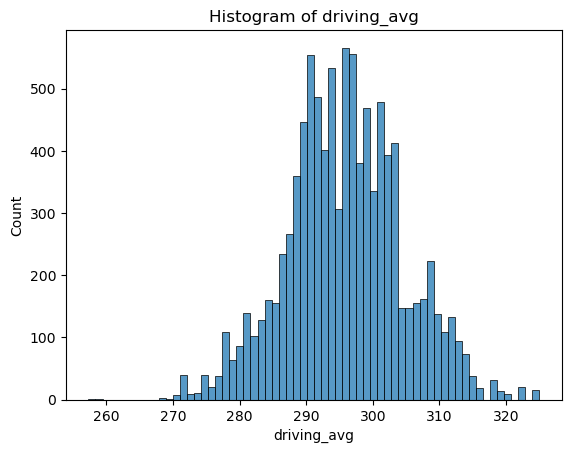

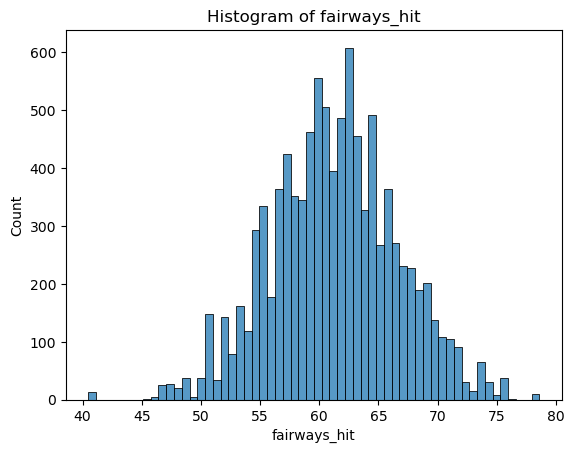

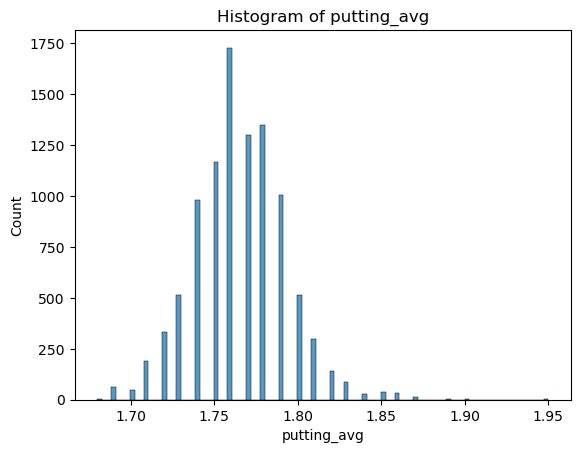

In [12]:
# use function to analyze summary statistics of selected features
prep.summarize(df)

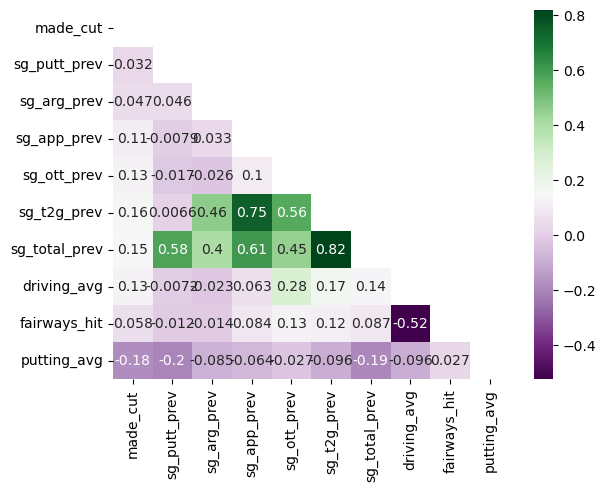

In [13]:
#checkout correlations
# Correlation heat map
figsize=(12, 8)
sns.heatmap(df.corr(method='pearson'), cmap='PRGn', annot=True,
           mask=np.triu(df.corr(method='pearson')))
plt.show()

# Train, Test, Split


In [14]:
#split data
train, validate, test = prep.split_data(df, 'made_cut')
train.head()

,date,course,tournament_name,made_cut,sg_putt_prev,sg_arg_prev,sg_app_prev,sg_ott_prev,sg_t2g_prev,sg_total_prev,driving_avg,fairways_hit,putting_avg
player,,,,,,,,,,,,,
Vaughn Taylor,2018-08-26,"Ridgewood - Paramus, NJ",The Northern Trust,0.0,-1.80,-0.61,-0.92,-0.56,-2.10,-3.90,292.7,60.9,1.80
Hudson Swafford,2020-06-28,"TPC River Highlands - Cromwell, CT",Travelers Championship,0.0,0.48,0.17,0.67,0.24,1.09,1.57,301.7,56.5,1.78
Cameron Tringale,2018-02-25,"PGA National - Palm Beach Gardens, FL",The Honda Classic,0.0,1.97,0.35,-0.29,-3.36,-3.30,-1.33,289.3,52.0,1.81
Retief Goosen,2018-04-02,"TPC Scottsdale - Scottsdale, AZ",Waste Management Phoenix Open,0.0,-0.10,-0.79,2.58,0.53,2.32,2.22,296.2,55.2,1.79
Sung Kang,2019-03-17,"TPC Sawgrass - Ponte Vedra Beach, FL",The Players Championship,1.0,1.37,0.30,0.26,0.40,0.96,2.32,300.5,60.7,1.78


In [15]:
# reset index
train = train.reset_index(drop=True)
validate = validate.reset_index(drop=True)
test = test.reset_index(drop=True)

# Set Target
- my target is whether or not someone makes the cut. Which is a categorical variable (I will use classification models to predict this outcome).

In [16]:
# check out target descriptive statistics
train.made_cut.value_counts()

1.0    3319
0.0    2572
Name: made_cut, dtype: int64

In [17]:
# baseline percentage of those who made cut
3319/(3319+2572)

0.5634017993549483

- if you were to pick at random a player and guess if they will make the cut, you'd be correct 56% of the time. This will be our baseline prediction.

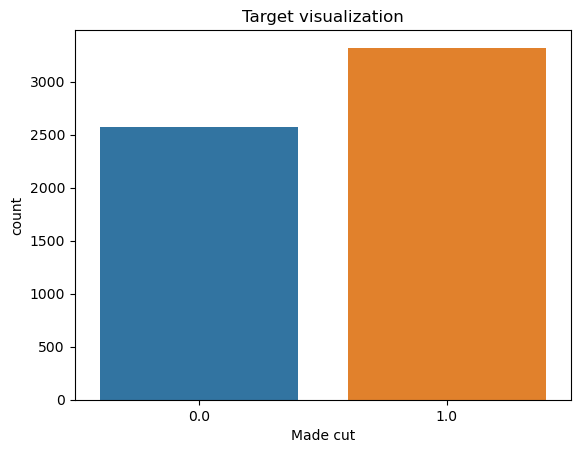

In [18]:
# visualize cuts made within the data set
sns.countplot(data=train, x= 'made_cut')
plt.title('Target visualization')
plt.xlabel('Made cut')
plt.show()

# Explore
- bivariate analysis

In [19]:
# set alpha for statistics tests
alpha = 0.05

# Do strokes gained putting in the previous week affect whether or not someone will make the cut this week?
- I want to explore whether or not previous performance is statistically significant in relation to making the cut
- I am comparing a continuous variable to a categorical so I will run a two-tailed ttest

$H_{0}$ : Mean strokes gained putting of players who made the cut <= Mean strokes gained putting of players who did not make the cut.

$H_{a}$ : Mean strokes gained putting of players who made the cut > Mean strokes gained putting of players who did not make the cut.

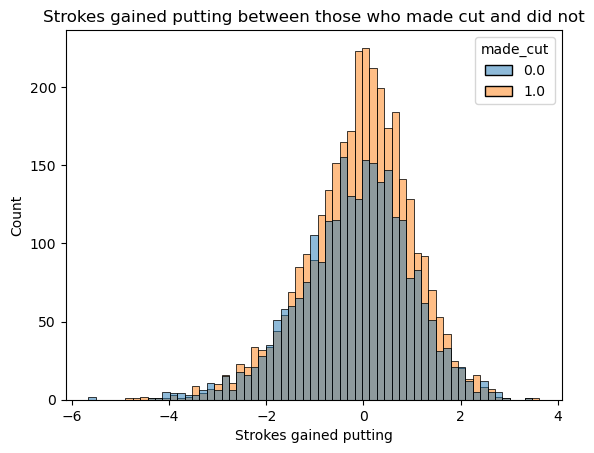

In [20]:
# visualize strokes gained putting in the previous week to making the cut in the next week
sns.histplot(data=train, x='sg_putt_prev', hue='made_cut')
plt.title('Strokes gained putting between those who made cut and did not')
plt.xlabel('Strokes gained putting')
plt.show()

##### Verify assumptions
- equal variances and normal distribution
    - Levene's test and Shapiro's test
    - We can use the central limit theorm to assume normalcy

In [21]:
# make sub groups of those who made or didn't make the cut based on strokes gained putting
made_cut_yes = train[train.made_cut == 1].sg_putt_prev
made_cut_no = train[train.made_cut == 0].sg_putt_prev

In [22]:
# compare means of the two groups
print('Strokes gained putting average of players who made cut:', made_cut_yes.mean())
print('Strokes gained putting average of players who did not make the cut:', made_cut_no.mean())

Strokes gained putting average of players who made cut: -0.088448327809581
Strokes gained putting average of players who did not make the cut: -0.16786547433903595


In [23]:
#verify equal variance
stat, p = levene(made_cut_yes, made_cut_no)
p

0.006701177574803022

- Levene's test results: The small p-value (less than alpha = 0.05) suggests that the populations do not have equal variances.

In [24]:
#run stats test
t, p = stats.ttest_ind(made_cut_yes, made_cut_no, equal_var=False)
t, p / 2

(2.696146572132059, 0.0035182177714112666)

In [25]:
if p/2 > alpha:
    print("We fail to reject $H_{0}$")
elif t < 0:
    print("We il to reject $H_{0}$")
else:
    print("We reject $H_{0}$")

We reject $H_{0}$


- Based on the p-value < alpha, we reject the null hypothesis. There is a relationship between strokes gained putting in the previous week and whether or not a player makes the cut in the following week.  I will use this feature in my model.

# Do strokes gained around green in the previous week affect whether or not someone will make the cut this week?
- I want to explore whether or not previous performance is statistically significant in relation to making the cut
- I am comparing a continuous variable to a categorical so I will run a two-tailed ttest

$H_{0}$ : Mean of strokes gained around the green of players who made the cut <= Mean of strokes gained around the green of players who did not make the cut.

$H_{a}$ : Mean of strokes gained around the green of players who made the cut > Mean of strokes gained around the green of players who did not make the cut.

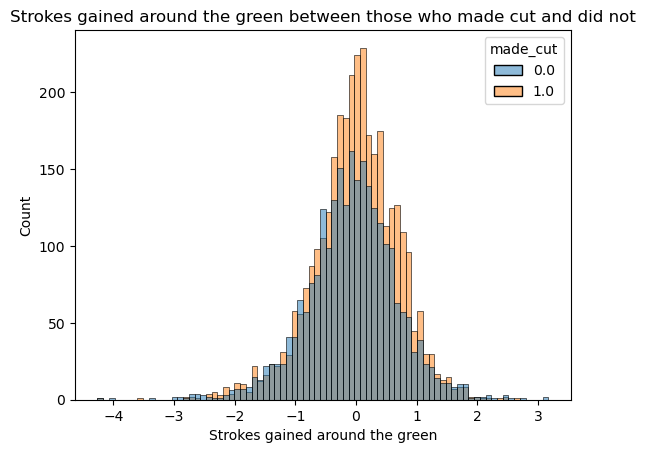

In [26]:
# visualize strokes gained around the green in the previous week to making the cut in the next week
sns.histplot(data=train, x='sg_arg_prev', hue='made_cut')
plt.title('Strokes gained around the green between those who made cut and did not')
plt.xlabel('Strokes gained around the green')
plt.show()

##### Verify assumptions
- equal variances and normal distribution
    - Levene's test and Shapiro's test
    - We can use the central limit theorm to assume normalcy

In [27]:
# make sub groups of those who made or didn't make the cut based on strokes gained around the green
made_cut_yes = train[train.made_cut == 1].sg_arg_prev
made_cut_no = train[train.made_cut == 0].sg_arg_prev

In [28]:
# compare means of the two groups
print('Strokes gained around the green average of players who made cut:', made_cut_yes.mean())
print('Strokes gained around the green average of players who did not make the cut:', made_cut_no.mean())

Strokes gained around the green average of players who made cut: -0.007734257306417589
Strokes gained around the green average of players who did not make the cut: -0.07503499222395042


In [29]:
#verify equal variance
stat, p = levene(made_cut_yes, made_cut_no)
p

0.0047857350258738735

- Levene's test results: The small p-value (less than alpha = 0.05) suggests that the populations do not have equal variances.

In [30]:
#run stats test
t, p = stats.ttest_ind(made_cut_yes, made_cut_no, equal_var=False)
t, p / 2

(3.5103253145715545, 0.00022563363444968643)

In [31]:
if p/2 > alpha:
    print("We fail to reject $H_{0}$")
elif t < 0:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")

We reject $H_{0}$


- Based on the p-value < alpha, we reject the null hypothesis. There is a relationship between strokes gained around the green in the previous week and whether or not a player makes the cut in the following week.  I will use this feature in my model.

# Do strokes gained approach in the previous week affect whether or not someone will make the cut this week?
- I want to explore whether or not previous performance is statistically significant in relation to making the cut
- I am comparing a continuous variable to a categorical so I will run a two-tailed ttest

$H_{0}$ : Mean of strokes gained approach of players who made the cut <= Mean of strokes gained approach of players who did not make the cut.

$H_{a}$ : Mean of strokes gained approach of players who made the cut > Mean of strokes gained approach of players who did not make the cut.

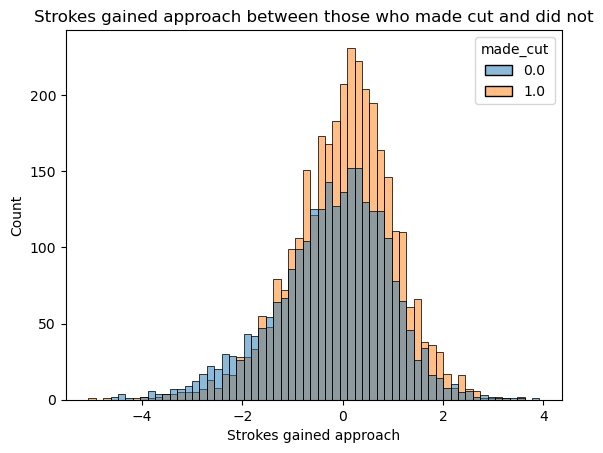

In [32]:
# visualize strokes gained approach in the previous week to making the cut in the next week
sns.histplot(data=train, x='sg_app_prev', hue='made_cut')
plt.title('Strokes gained approach between those who made cut and did not')
plt.xlabel('Strokes gained approach')
plt.show()

##### Verify assumptions
- equal variances and normal distribution
    - Levene's test and Shapiro's test
    - We can use the central limit theorm to assume normalcy

In [33]:
# make sub groups of those who made or didn't make the cut based on strokes gained approach
made_cut_yes = train[train.made_cut == 1].sg_app_prev
made_cut_no = train[train.made_cut == 0].sg_app_prev

In [34]:
# compare means of the two groups
print('Strokes gained approach average of players who made cut:', made_cut_yes.mean())
print('Strokes gained approach average of players who did not make the cut:', made_cut_no.mean())

Strokes gained approach average of players who made cut: 0.014962338053630618
Strokes gained approach average of players who did not make the cut: -0.2232659409020215


In [35]:
#verify equal variance
stat, p = levene(made_cut_yes, made_cut_no)
p

1.448967698018411e-09

- Levene's test results: The small p-value (less than alpha = 0.05) suggests that the populations do not have equal variances.

In [36]:
#run stats test
t, p = stats.ttest_ind(made_cut_yes, made_cut_no, equal_var=False)
t, p / 2

(8.243575950997608, 1.0500837561342824e-16)

In [37]:
if p/2 > alpha:
    print("We fail to reject $H_{0}$")
elif t < 0:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")

We reject $H_{0}$


- Based on the p-value < alpha, we reject the null hypothesis. There is a relationship between strokes gained approach in the previous week and whether or not a player makes the cut in the following week.  I will use this feature in my model.

# Do strokes gained off-the-tee in the previous week affect whether or not someone will make the cut this week?
- I want to explore whether or not previous performance is statistically significant in relation to making the cut
- I am comparing a continuous variable to a categorical so I will run a two-tailed ttest

$H_{0}$ : Mean of strokes gained off-the-tee of players who made the cut <= Mean of strokes gained off-the-tee of players who did not make the cut.

$H_{a}$ : Mean of strokes gained off-the-tee of players who made the cut > Mean of strokes gained off-the-tee of players who did not make the cut.

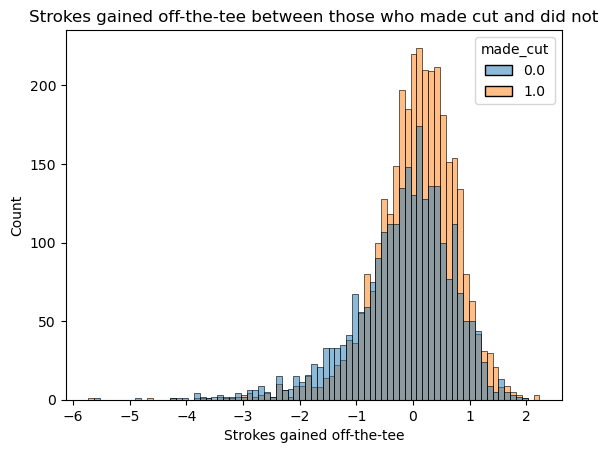

In [38]:
# visualize strokes gained off-the-tee in the previous week to making the cut in the next week
sns.histplot(data=train, x='sg_ott_prev', hue='made_cut')
plt.title('Strokes gained off-the-tee between those who made cut and did not')
plt.xlabel('Strokes gained off-the-tee')
plt.show()

##### Verify assumptions
- equal variances and normal distribution
    - Levene's test and Shapiro's test
    - We can use the central limit theorm to assume normalcy

In [39]:
# make sub groups of those who made or didn't make the cut based on strokes gained off-the-tee
made_cut_yes = train[train.made_cut == 1].sg_ott_prev
made_cut_no = train[train.made_cut == 0].sg_ott_prev

In [40]:
# compare means of the two groups
print('Strokes gained off-the-tee average of players who made cut:', made_cut_yes.mean())
print('Strokes gained off-the-tee average of players who did not make the cut:', made_cut_no.mean())

Strokes gained off-the-tee average of players who made cut: 0.04005122024706228
Strokes gained off-the-tee average of players who did not make the cut: -0.1782581648522549


In [41]:
#verify equal variance
stat, p = levene(made_cut_yes, made_cut_no)
p

5.679958414751567e-15

- Levene's test results: The small p-value (less than alpha = 0.05) suggests that the populations do not have equal variances.

In [42]:
#run stats test
t, p = stats.ttest_ind(made_cut_yes, made_cut_no, equal_var=False)
t, p / 2

(10.042542995523078, 8.273281028516683e-24)

In [43]:
if p/2 > alpha:
    print("We fail to reject $H_{0}$")
elif t < 0:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")

We reject $H_{0}$


- Based on the p-value < alpha, we reject the null hypothesis. There is a relationship between strokes gained off-the-tee in the previous week and whether or not a player makes the cut in the following week.  I will use this feature in my model.

# Do strokes gained tee-to-green in the previous week affect whether or not someone will make the cut this week?
- I want to explore whether or not previous performance is statistically significant in relation to making the cut
- I am comparing a continuous variable to a categorical so I will run a two-tailed ttest

$H_{0}$ : Mean of strokes gained tee-to-green of players who made the cut <= Mean of strokes gained tee-to-green of players who did not make the cut.

$H_{a}$ : Mean of strokes gained tee-to-green of players who made the cut > Mean of strokes gained tee-to-green of players who did not make the cut.

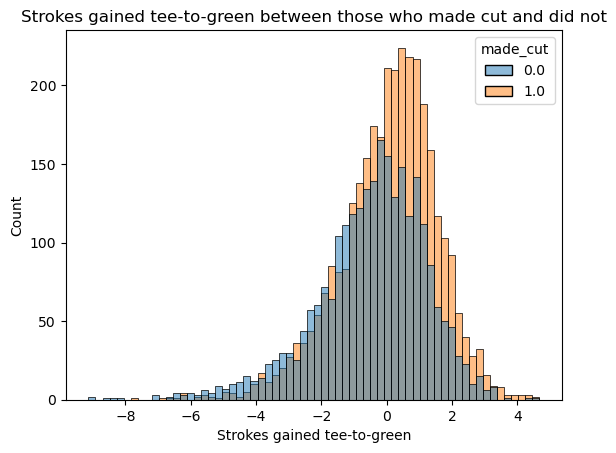

In [44]:
# visualize strokes gained tee-to-green in the previous week to making the cut in the next week
sns.histplot(data=train, x='sg_t2g_prev', hue='made_cut')
plt.title('Strokes gained tee-to-green between those who made cut and did not')
plt.xlabel('Strokes gained tee-to-green')
plt.show()

##### Verify assumptions
- equal variances and normal distribution
    - Levene's test and Shapiro's test
    - We can use the central limit theorm to assume normalcy

In [45]:
# make sub groups of those who made or didn't make the cut based on strokes gained tee-to-green
made_cut_yes = train[train.made_cut == 1].sg_t2g_prev
made_cut_no = train[train.made_cut == 0].sg_t2g_prev

In [46]:
# compare means of the two groups
print('Strokes gained tee-to-green average of players who made cut:', made_cut_yes.mean())
print('Strokes gained tee-to-green average of players who did not make the cut:', made_cut_no.mean())

Strokes gained tee-to-green average of players who made cut: 0.04729737872853261
Strokes gained tee-to-green average of players who did not make the cut: -0.47663297045101055


In [47]:
#verify equal variance
stat, p = levene(made_cut_yes, made_cut_no)
p

2.1765160912276285e-06

- Levene's test results: The small p-value (less than alpha = 0.05) suggests that the populations do not have equal variances.

In [48]:
#run stats test
t, p = stats.ttest_ind(made_cut_yes, made_cut_no, equal_var=False)
t, p / 2

(12.33964514032601, 8.416688270046493e-35)

In [49]:
if p/2 > alpha:
    print("We fail to reject $H_{0}$")
elif t < 0:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")

We reject $H_{0}$


- Based on the p-value < alpha, we reject the null hypothesis. There is a relationship between strokes gained tee-to-green in the previous week and whether or not a player makes the cut in the following week.  I will use this feature in my model.

# Do strokes gained total in the previous week affect whether or not someone will make the cut this week?
- I want to explore whether or not previous performance is statistically significant in relation to making the cut
- I am comparing a continuous variable to a categorical so I will run a two-tailed ttest

$H_{0}$ : Mean of strokes gained total of players who made the cut <= Mean of strokes gained total of players who did not make the cut.

$H_{a}$ : Mean of strokes gained total of players who made the cut > Mean of strokes gained total of players who did not make the cut.

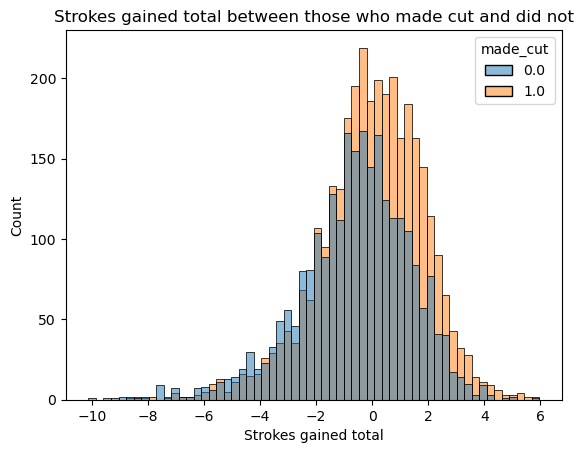

In [50]:
# visualize strokes gained total in the previous week to making the cut in the next week
sns.histplot(data=train, x='sg_total_prev', hue='made_cut')
plt.title('Strokes gained total between those who made cut and did not')
plt.xlabel('Strokes gained total')
plt.show()

##### Verify assumptions
- equal variances and normal distribution
    - Levene's test and Shapiro's test
    - We can use the central limit theorm to assume normalcy

In [51]:
# make sub groups of those who made or didn't make the cut based on strokes gained total
made_cut_yes = train[train.made_cut == 1].sg_total_prev
made_cut_no = train[train.made_cut == 0].sg_total_prev

In [52]:
# compare means of the two groups
print('Strokes gained total of players who made cut:', made_cut_yes.mean())
print('Strokes gained total of players who did not make the cut:', made_cut_no.mean())

Strokes gained total of players who made cut: -0.04110876770111489
Strokes gained total of players who did not make the cut: -0.6443351477449428


In [53]:
#verify equal variance
stat, p = levene(made_cut_yes, made_cut_no)
p

0.01728350569850986

- Levene's test results: The small p-value (less than alpha = 0.05) suggests that the populations do not have equal variances.

In [54]:
#run stats test
t, p = stats.ttest_ind(made_cut_yes, made_cut_no, equal_var=False)
t, p / 2

(11.68073420872699, 1.907929309170329e-31)

In [55]:
if p/2 > alpha:
    print("We fail to reject $H_{0}$")
elif t < 0:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")

We reject $H_{0}$


- Based on the p-value < alpha, we reject the null hypothesis. There is a relationship between strokes gained total in the previous week and whether or not a player makes the cut in the following week.  I will use this feature in my model.

# Does driving average affect whether or not someone will make the cut?
- I want to explore whether or not previous performance is statistically significant in relation to making the cut
- I am comparing a continuous variable to a categorical so I will run a two-tailed ttest

$H_{0}$ : Mean driving average of players who made the cut <= Mean driving average of players who did not make the cut.

$H_{a}$ : Mean driving average of players who made the cut > Mean driving average of players who did not make the cut.

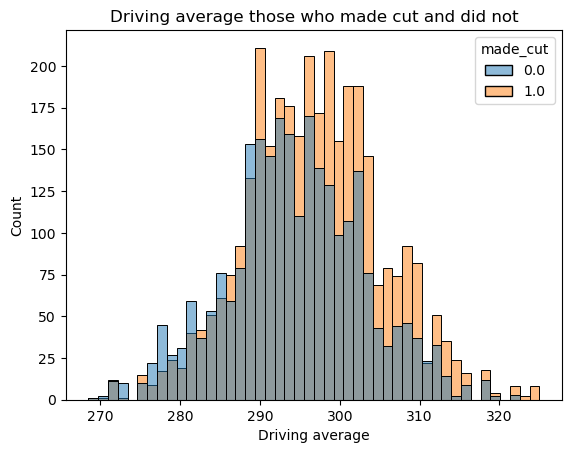

In [56]:
# visualize driving average to making the cut 
sns.histplot(data=train, x='driving_avg', hue='made_cut')
plt.title('Driving average those who made cut and did not')
plt.xlabel('Driving average')
plt.show()

##### Verify assumptions
- equal variances and normal distribution
    - Levene's test and Shapiro's test
    - We can use the central limit theorm to assume normalcy

In [57]:
# make sub groups of those who made or didn't make the cut based on driving average
made_cut_yes = train[train.made_cut == 1].driving_avg
made_cut_no = train[train.made_cut == 0].driving_avg

In [58]:
# compare means of the two groups
print('Driving average of players who made cut:', made_cut_yes.mean())
print('Driving average of players who did not make the cut:', made_cut_no.mean())

Driving average of players who made cut: 296.7669177463086
Driving average of players who did not make the cut: 294.4361586314157


In [59]:
#verify equal variance
stat, p = levene(made_cut_yes, made_cut_no)
p

0.8585647575642807

- Levene's test results: The p-value (larger than alpha = 0.05) suggests that the populations do have equal variances.

In [60]:
#run stats test
t, p = stats.ttest_ind(made_cut_yes, made_cut_no, equal_var=True)
t, p / 2

(10.322599403463704, 4.523782735075657e-25)

In [61]:
if p/2 > alpha:
    print("We fail to reject $H_{0}$")
elif t < 0:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")

We reject $H_{0}$


- Based on the p-value < alpha, we reject the null hypothesis. There is a relationship between driving average and whether or not a player makes the cut.  I will use this feature in my model.

# Do fairways hit percentage affect whether or not someone will make the cut?
- I want to explore whether or not previous performance is statistically significant in relation to making the cut
- I am comparing a continuous variable to a categorical so I will run a two-tailed ttest

$H_{0}$ : Mean fairways hit of players who made the cut <= Mean fairways hit of players who did not make the cut.

$H_{a}$ : Mean fairways hit of players who made the cut > Mean fairways hit of players who did not make the cut.

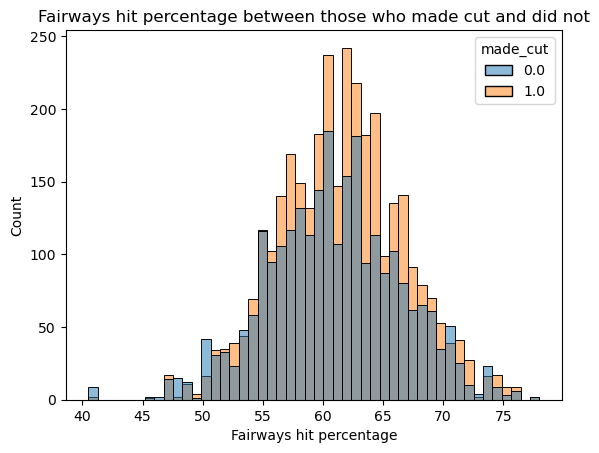

In [62]:
# visualize fairways hit percentage to making the cut 
sns.histplot(data=train, x='fairways_hit', hue='made_cut')
plt.title('Fairways hit percentage between those who made cut and did not')
plt.xlabel('Fairways hit percentage')
plt.show()

##### Verify assumptions
- equal variances and normal distribution
    - Levene's test and Shapiro's test
    - We can use the central limit theorm to assume normalcy

In [63]:
# make sub groups of those who made or didn't make the cut based on fairways hit
made_cut_yes = train[train.made_cut == 1].fairways_hit
made_cut_no = train[train.made_cut == 0].fairways_hit

In [64]:
# compare means of the two groups
print('Fairways hit percentage of players who made cut:', made_cut_yes.mean())
print('Fairways hit percentage of players who did not make the cut:', made_cut_no.mean())

Fairways hit percentage of players who made cut: 61.47240132570047
Fairways hit percentage of players who did not make the cut: 60.8847589424572


In [65]:
#verify equal variance
stat, p = levene(made_cut_yes, made_cut_no)
p

0.00013587711884526196

- Levene's test results: The small p-value (less than alpha = 0.05) suggests that the populations do not have equal variances.

In [66]:
#run stats test
t, p = stats.ttest_ind(made_cut_yes, made_cut_no, equal_var=False)
t, p / 2

(4.11451658708387, 1.9693760558677147e-05)

In [67]:
if p/2 > alpha:
    print("We fail to reject $H_{0}$")
elif t < 0:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")

We reject $H_{0}$


- Based on the p-value < alpha, we reject the null hypothesis. There is a relationship between fairways hit and whether or not a player makes the cut. I will use this feature in my model.

# Does putting average affect whether or not someone will make the cut?
- I want to explore whether or not previous performance is statistically significant in relation to making the cut
- I am comparing a continuous variable to a categorical so I will run a two-tailed ttest

$H_{0}$ : Mean putting average of players who made the cut >= Mean putting average of players who did not make the cut.

$H_{a}$ : Mean putting average of players who made the cut < Mean putting average of players who did not make the cut.

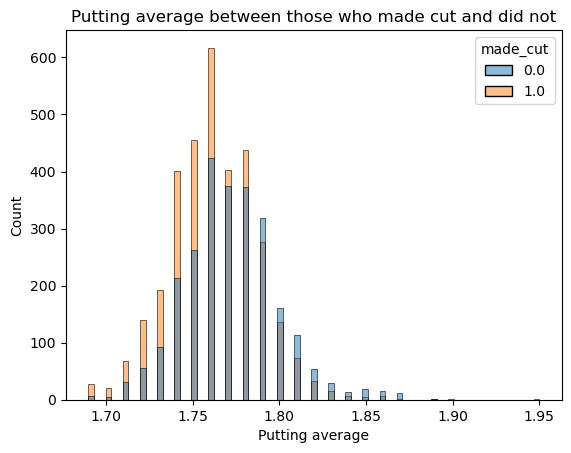

In [68]:
# visualize putting average to making the cut 
sns.histplot(data=train, x='putting_avg', hue='made_cut')
plt.title('Putting average between those who made cut and did not')
plt.xlabel('Putting average')
plt.show()

##### Verify assumptions
- equal variances and normal distribution
    - Levene's test and Shapiro's test
    - We can use the central limit theorm to assume normalcy

In [69]:
# make sub groups of those who made or didn't make the cut based on fairways hit
made_cut_yes = train[train.made_cut == 1].putting_avg
made_cut_no = train[train.made_cut == 0].putting_avg

In [70]:
# compare means of the two groups
print('Putting average of players who made cut:', made_cut_yes.mean())
print('Putting average of players who did not make the cut:', made_cut_no.mean())

Putting average of players who made cut: 1.7614522446520227
Putting average of players who did not make the cut: 1.771582426127545


In [71]:
#verify equal variance
stat, p = levene(made_cut_yes, made_cut_no)
p

0.012160059047307686

- Levene's test results: The small p-value (less than alpha = 0/05) suggests that the populations do not have equal variances.

In [72]:
#run stats test
t, p = stats.ttest_ind(made_cut_yes, made_cut_no, equal_var=False)
t, p / 2

(-14.269191426240049, 1.1442497196485306e-45)

In [73]:
if p/2 > alpha:
    print("We fail to reject $H_{0}$")
elif t < 0:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")

We fail to reject $H_{0}$


- Based on the p-value < alpha, we reject the null hypothesis. There is a relationship between putting average and whether or not a player makes the cut. I will use this feature in my model.

# Exploration Takeway

- Golf is a game of inches. Differences in strokes gained and lost throughout a tournament and the comparison between the two groups (made the cut, did not make the cut) paint a picture of razor thin margins when describing success (making the cut) on tour. 


- ***Strokes gained putting***
    - Strokes gained putting average of players who made cut: -0.088
    - Strokes gained putting average of players who did not make the cut: -0.16
- ***Strokes gained around the green***
    - Strokes gained around the green average of players who made cut: -0.008
    - Strokes gained around the green average of players who did not make the cut: -0.075
- ***Strokes gained approach***
    - Strokes gained approach average of players who made cut: 0.015
    - Strokes gained approach average of players who did not make the cut: -0.22
- ***Strokes gained off-the-tee***
    - Strokes gained off-the-tee average of players who made cut: 0.04
    - Strokes gained off-the-tee average of players who did not make the cut: -0.17
- ***Strokes gained tee-to-green***    
    - Strokes gained tee-to-green average of players who made cut: 0.047
    - Strokes gained tee-to-green average of players who did not make the cut: -0.476
- ***Strokes gained total***
    - Strokes gained total of players who made cut: -0.041
    - Strokes gained total of players who did not make the cut: -0.644
- ***Driving average***
    - Driving average of players who made cut: 296.77
    - Driving average of players who did not make the cut: 294.44
- ***Fairways hit***
    - Fairways hit percentage of players who made cut: 61.47
    - Fairways hit percentage of players who did not make the cut: 60.89
- ***Putting average***
    - Putting average of players who made cut: 1.761
    - Putting average of players who did not make the cut: 1.771

    
- All features are statistically significant to the target of whether or not a player will make the cut. 
    - The following features seem to have the biggest impact
        - Strokes gained approach
        - Strokes gained off-the-tee 
        - Strokes gained tee-to-green 
        - Strokes gained total
- Since all features are statistically significant and do not violate our statistical assumptions. I will run them through various classification models. 

# Modeling
- I have found significance in my independent variables, I will model those against the target using the following models to determine the best predictive model:

>- Decision tree
>- Random forest
>- KNN
>- Logistic regression

### Scale data for modeling

In [74]:
# scale data for modeling
X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test = prep.scaled_df(train, validate, test)
X_train_scaled.head()

,sg_putt_prev,sg_arg_prev,sg_app_prev,sg_ott_prev,sg_t2g_prev,sg_total_prev,driving_avg,fairways_hit,putting_avg
0,0.415948,0.491252,0.461624,0.649497,0.509420,0.386816,0.428319,0.544000,0.423077
1,0.661638,0.596231,0.638487,0.750000,0.740580,0.726990,0.587611,0.426667,0.346154
2,0.822198,0.620458,0.531702,0.297739,0.422464,0.546642,0.368142,0.306667,0.461538
3,0.599138,0.467026,0.850945,0.786432,0.829710,0.767413,0.490265,0.392000,0.384615
4,0.757543,0.613728,0.592881,0.770101,0.731159,0.773632,0.566372,0.538667,0.346154


### Define baseline and visualize target variable

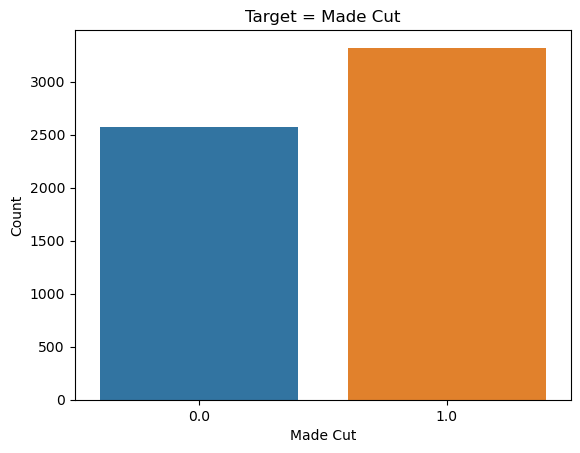

In [75]:
# visualize target
muah.plot_target(train)

In [76]:
# set baseline accuracy
train.made_cut.mean()

0.5634017993549483

# Decision Tree
- run function to iterate through hyperparameters and find best fitting model



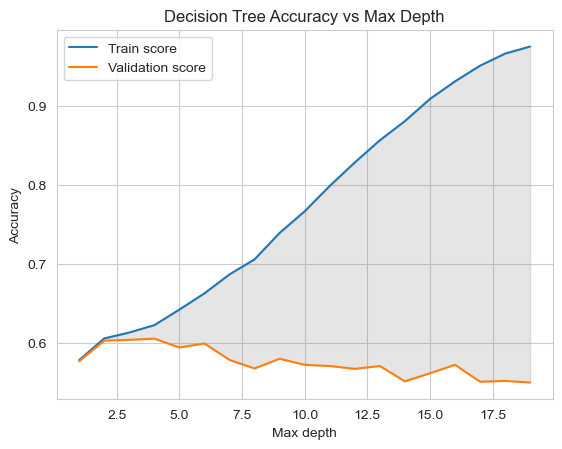

,max_depth,train_acc,val_acc,score_diff
1,2,0.60567,0.602851,0.002818


In [77]:
muah.decision_tree(X_train_scaled, X_validate_scaled, y_train, y_validate)[1:2]

# Random Forest
- run function to iterate through hyperparameters and find best fitting model

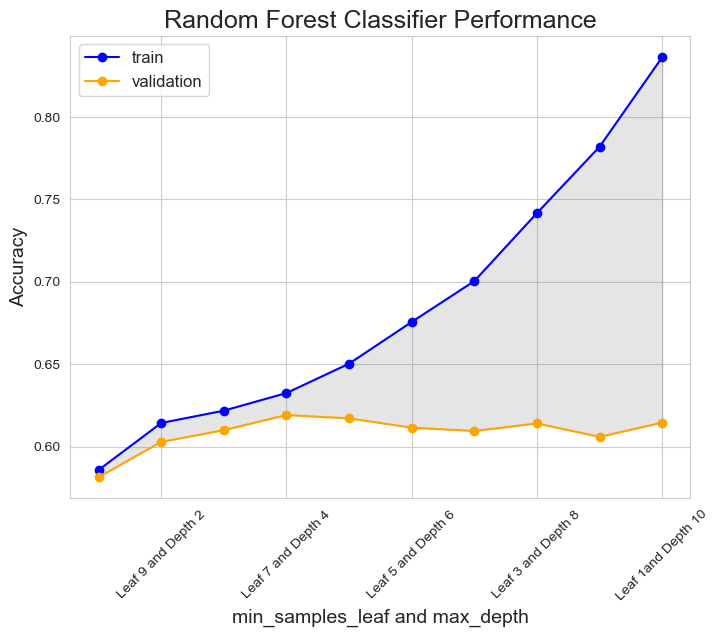

,min_samples_leaf,max_depth,train_score,validate_score,diff_score
6,7,4,0.63249,0.619145,0.013346


In [78]:
muah.random_forest_scores(X_train_scaled, y_train, X_validate_scaled, y_validate)[6:7]

# KNN
- run function to iterate through hyperparameters and find best fitting model


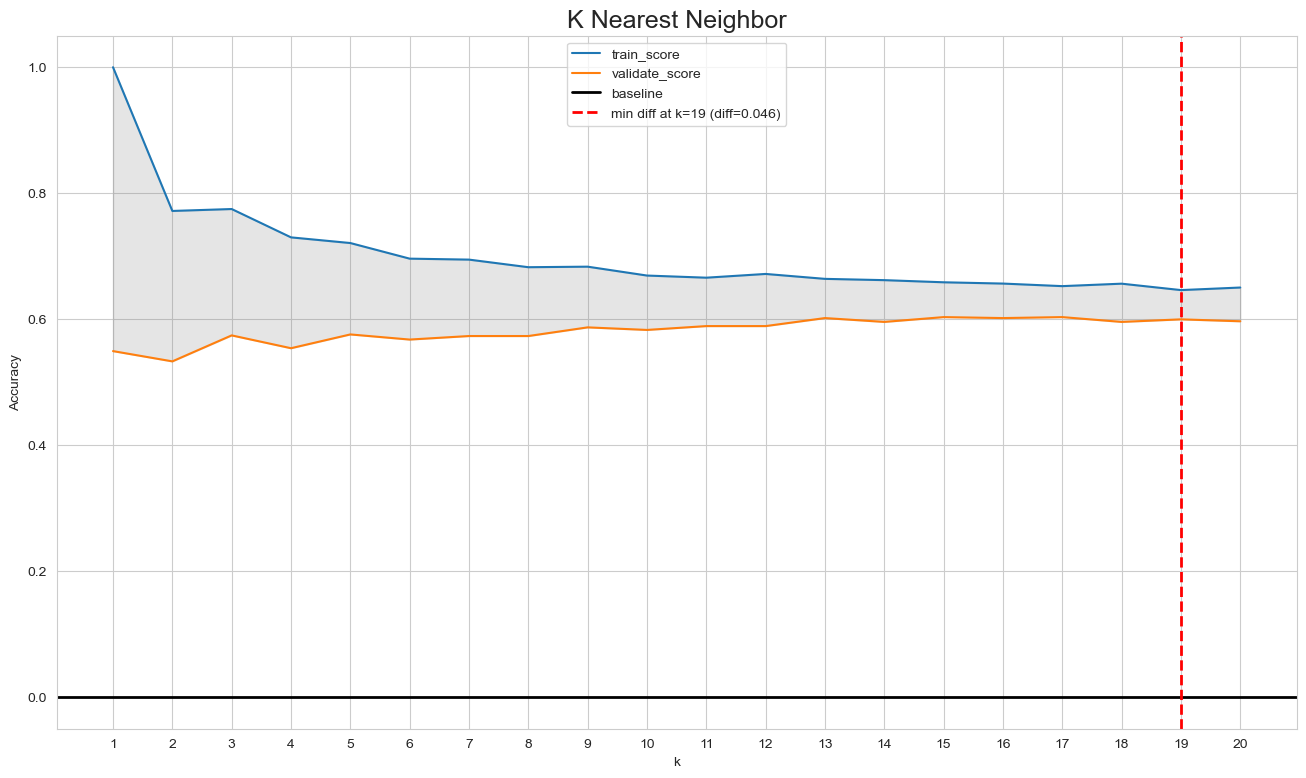

,k,train_score,validate_score,diff_score
16,17,0.652521,0.60336,0.04916


In [79]:
k.k_nearest2(X_train_scaled, y_train, X_validate_scaled, y_validate)[16:17]

# Logistic Regression
- run function to iterate through hyperparameters and find best fitting model

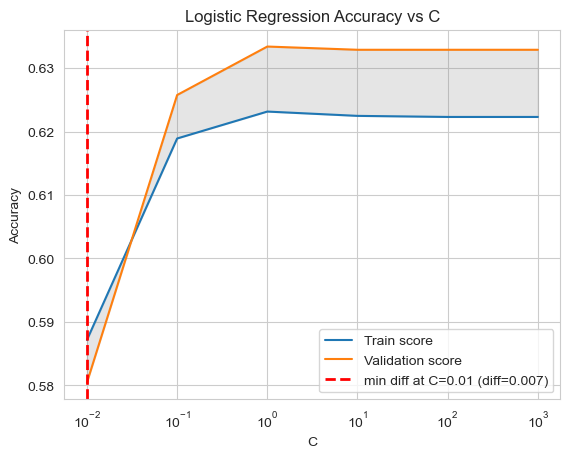

,C,train_score,validate_score,diff_score
1,0.1,0.61891,0.625764,-0.006854


In [80]:
muah.plot_logistic_regression(X_train_scaled, X_validate_scaled, y_train, y_validate)[1:2]

# Compare models

| ***Decision tree*** |                   |                   |                   |                   |
|---------------------|-------------------|-------------------|-------------------|-------------------|
| Max Depth           |                   | Train Accuracy    | Validate Accuracy | Score Difference  |
| 2                   |                   | 0.60567           | 0.602851          | 0.002818          |
|---------------------|-------------------|-------------------|-------------------|-------------------|
| ***Random forest*** |                   |                   |                   |                   |
| Min Samples Leaf    | Max Depth         | Train Accuracy    | Validate Accuracy | Score Difference  |
| 7                   | 4                 | 0.63249           | 0.619145          | 0.013346          |
|---------------------|-------------------|-------------------|-------------------|-------------------|
| ***KNN***           |                   |                   |                   |                   |
| k                   |                   | Train Accuracy    | Validate Accuracy | Score Difference  |
| 17                  |                   | 0.652521          | 0.603360          | 0.049160          |
|---------------------|-------------------|-------------------|-------------------|-------------------|
| ***Logistic Regression*** |             |                   |                   |                   |
| C                   |                   | Train Accuracy    | Validate Accuracy |  Score Difference |
| 0.10                |                   | 0.618910          | 0.625764          |-0.006854          |



               

> - I am choosing logistic regression for my model. The hyperparameter is set at C = 0.10. Test data will be ran through the model.

# Run best model on test data

In [81]:
#run function with test data on logistic regression
muah.the_chosen_one2(X_train_scaled, X_test_scaled, y_train, y_test)

0.6084521384928717

> - The logistic regression model performs at 61% accuracy on unseen test data. 

# Summary
- The data analysis pipeline (Acquire, Prepare, Explore, Modeling) was completed.
- All features selected were statistically significant. 
    - These features seemed to be the most important factors
        - Strokes gained approach
        - Strokes gained off-the-tee 
        - Strokes gained tee-to-green 
        - Strokes gained total
- Scaled data with selected features were ran through 4 different predictive models:
    - Decision Tree
    - Random Forest
    - KNN
    - Logistic Regression
        - Out of the four models, logistic regression performed the best. 
            - The model scored 61% on the unseen test data set. 5% better than the baseline of 56%.
            
# Recommendations
- Using this model as a guide, players and sponsors can predict next weeks performance (with 61% accuracy) based on last weeks performance. 
    - In preparation for a tournament, focus on the following to ensure best chances of making the cut:
        - Strokes gained approach
        - Strokes gained off-the-tee 
        - Strokes gained tee-to-green 
            - Tee ball accuracy and iron accuracy are premium stats. They add the most strokes to players scorecards 
    - ***Caveat*** -- There are too many unquantifiable variables to predict with 100% certainty whether or not a player will make the cut or not. 
    
# Next Steps
- To further investigate the possibility of a powerful predictive model hidden within this dataset:
    - I will continue to work on adding weather attributes, through clustering
    - Model course slope and length into the equation
    - Explore player demographics (age, height, weight).